In [1]:
import os
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchnet
import torchvision.models as models
import torchvision.transforms as transforms
from munch import Munch
from sklearn.metrics import auc, roc_curve, roc_auc_score
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

import datasets

In [2]:
# pytorch 1.0.0 and torchvision 0.1.9
import torchvision
assert '0.1.9' in torchvision.__file__

In [3]:
# pretrained resnet152_3class
config_path = 'pretrained/resnet152_3class/config.yml'
epoch = 5

In [4]:
#config_path = 'logs/your_log_dir/config.yml'
#epoch = your_best_epoch

In [5]:
with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

In [6]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

print("=> creating model '{}'".format(cfg.arch.model))
model = models.__dict__[cfg.arch.model]()

if cfg.arch.model == 'resnet152':
    model.fc = nn.Linear(2048, cfg.arch.num_classes)
else:
    raise Exception

model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True

=> creating model 'resnet152'


In [7]:
resume_path = cfg.training.resume.replace(cfg.training.resume[-16:-8], '{:08}'.format(epoch))
if os.path.isfile(resume_path):
    print("=> loading checkpoint '{}'".format(resume_path))
    checkpoint = torch.load(resume_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print("=> loaded checkpoint '{}' (epoch {})".format(resume_path, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_path))
    print('')
    raise Exception

=> loading checkpoint 'pretrained/resnet152_3class/checkpoint_00000005.pth.tar'
=> loaded checkpoint 'pretrained/resnet152_3class/checkpoint_00000005.pth.tar' (epoch 5)


In [8]:
# Note that unlike the 2class evaluation, here we use the test dataset instead of the val dataset
split = 'test'
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
dataset = datasets.DDSM(cfg.data.root, split, transforms.Compose([
    transforms.ToTensor(),
    normalize,
]))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.data.batch_size, shuffle=False,
    num_workers=cfg.data.workers, pin_memory=True)

In [9]:
targets = [[] for _ in range(cfg.arch.num_classes)]
probs = [[] for _ in range(cfg.arch.num_classes)]
aucs = [torchnet.meter.AUCMeter() for _ in range(cfg.arch.num_classes)]

with torch.no_grad():
    for input, target in tqdm(data_loader):
        output = model(input)
        prob = nn.Softmax(dim=1)(output)
        for i in range(cfg.arch.num_classes):
            aucs[i].add(prob[:, i], target == i)
            targets[i].extend(target.numpy() == i)
            probs[i].extend(prob[:, i].cpu().numpy())

for i in range(cfg.arch.num_classes):
    print('class {}'.format(i))
    print('torchnet.meter.AUCMeter: {}'.format(aucs[i].value()[0]))
    print('sklearn.metrics.roc_auc_score: {}'.format(roc_auc_score(targets[i], probs[i])))
    print('')


class 0
torchnet.meter.AUCMeter: 0.86178807757593
sklearn.metrics.roc_auc_score: 0.8617880404009961

class 1
torchnet.meter.AUCMeter: 0.8440969899037686
sklearn.metrics.roc_auc_score: 0.8440969805171643

class 2
torchnet.meter.AUCMeter: 0.871929004904548
sklearn.metrics.roc_auc_score: 0.871929004904548



In [10]:
def plot_roc_curve(y_true, y_score):
    plt.figure(figsize=(8, 8))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, color='black')
    plt.show()

class 0


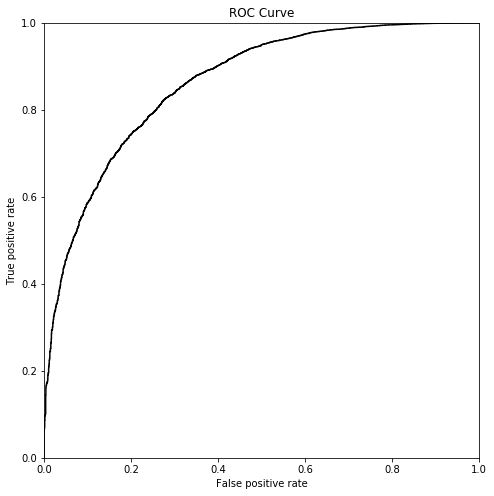

class 1


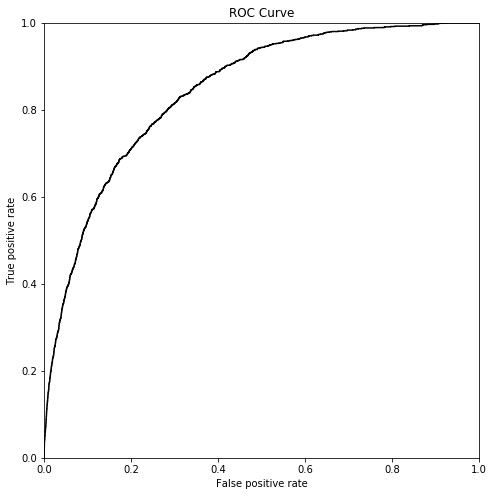

class 2


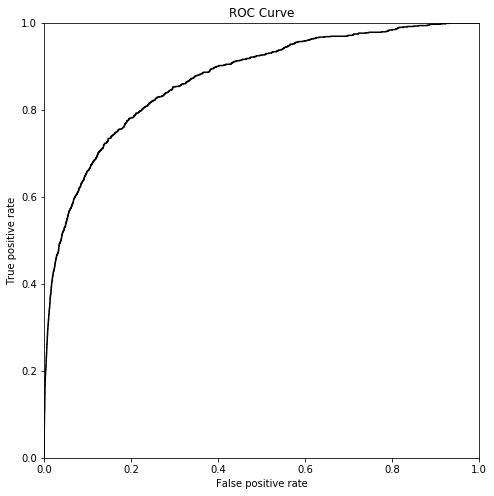

In [11]:
for i in range(cfg.arch.num_classes):
    print('class {}'.format(i))
    plot_roc_curve(targets[i], probs[i])

In [12]:
def partial_auc(fpr, tpr, thresh):
    loc = len([t for t in tpr if t >= thresh])
    pAUC = np.trapz(tpr[-1*loc:], fpr[-1*loc:]) * (1-thresh)
    return pAUC

In [13]:
# Print partial AUC over threshold of 0.8 

i = 1
fpr, tpr, _ = roc_curve(targets[i], probs[i])
pAUC = partial_auc(fpr, tpr, 0.8)
print(pAUC)

0.1363927674337399


In [14]:
# Plot for all 3 classes' ROC and pAUC 

def plot_multi_roc_curve(ys_true, ys_score, legend):
    n_classes = len(ys_true)
    
    # First aggregate all false positive rates
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    pauc = dict()
    for i in range(n_classes):        
        fpr[i], tpr[i], _ = roc_curve(ys_true[i], ys_score[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        pauc[i] = partial_auc(fpr[i], tpr[i], thresh = 0.8)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal')
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Class {0} ( AUC = {1:0.3f}, pAUC = {2:0.3f} )'
                 ''.format(legend[i], roc_auc[i], pauc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.plot([0, 1], [0.8, 0.8], color='navy', linestyle=':', 
             lw=lw, label='Partial AUC threshold = 0.8 TPR')

    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    #plt.title('ResNet152 3class ROC')
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

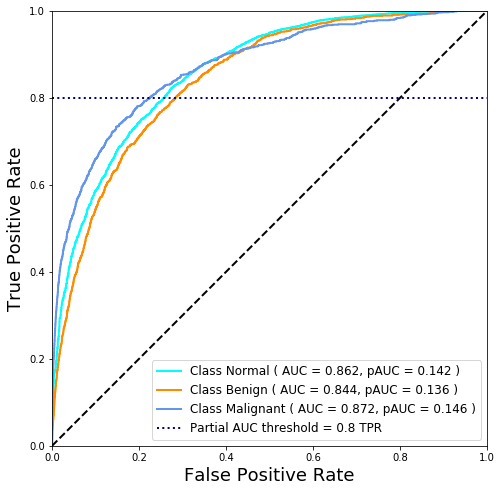

In [15]:
# ROC curves for each class overlayed, with pAUC indicated
plot_multi_roc_curve(targets, probs, ['Normal', 'Benign', 'Malignant'])